In [553]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import uniform, randint

In [554]:
columns = ["Date", "Close", "High", "Low", "Open", "Volume"]

AAPL_prices = pd.read_csv("../data/raw/yf_prices/AAPL.csv")
AMZN_prices = pd.read_csv("../data/raw/yf_prices/AMZN.csv")
BA_prices = pd.read_csv("../data/raw/yf_prices/BA.csv")
CAT_prices = pd.read_csv("../data/raw/yf_prices/CAT.csv")
CVX_prices = pd.read_csv("../data/raw/yf_prices/CVX.csv")
GS_prices = pd.read_csv("../data/raw/yf_prices/GS.csv")
JNJ_prices = pd.read_csv("../data/raw/yf_prices/JNJ.csv")
JPM_prices = pd.read_csv("../data/raw/yf_prices/JPM.csv")
MSFT_prices = pd.read_csv("../data/raw/yf_prices/MSFT.csv")
NEE_prices = pd.read_csv("../data/raw/yf_prices/NEE.csv")
NVDA_prices = pd.read_csv("../data/raw/yf_prices/NVDA.csv")
PFE_prices = pd.read_csv("../data/raw/yf_prices/PFE.csv")
TSLA_prices = pd.read_csv("../data/raw/yf_prices/TSLA.csv")
XOM_prices = pd.read_csv("../data/raw/yf_prices/XOM.csv")

In [555]:
def clean_prices_df(df):
    df = df.copy()
    df.rename(columns={"Price": "Date"}, inplace=True)
    df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
    df = df.dropna(subset=["Close"]).reset_index(drop=True)
    for col in ["High", "Low", "Open", "Volume"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    return df

In [556]:
AAPL_prices = clean_prices_df(AAPL_prices)
AMZN_prices = clean_prices_df(AMZN_prices)
BA_prices = clean_prices_df(BA_prices)
CAT_prices = clean_prices_df(CAT_prices)
CVX_prices = clean_prices_df(CVX_prices)
GS_prices = clean_prices_df(GS_prices)
JNJ_prices = clean_prices_df(JNJ_prices)
JPM_prices = clean_prices_df(JPM_prices)
MSFT_prices = clean_prices_df(MSFT_prices)
NEE_prices = clean_prices_df(NEE_prices)
NVDA_prices = clean_prices_df(NVDA_prices)
PFE_prices = clean_prices_df(PFE_prices)
TSLA_prices = clean_prices_df(TSLA_prices)
XOM_prices = clean_prices_df(XOM_prices)

In [557]:
def feature_engineer_prices_df(df):
    df = df.copy()

    # --- Basic price change features ---
    df["Return_1d"] = df["Close"].pct_change()
    df["Return_7d"] = df["Close"].pct_change(7)

    # --- Moving averages ---
    df["MA_7"] = df["Close"].rolling(window=7).mean()
    df["MA_14"] = df["Close"].rolling(window=14).mean()
    df["MA_30"] = df["Close"].rolling(window=30).mean()

    # --- Volatility ---
    df["Volatility_7d"] = df["Return_1d"].rolling(window=7).std()
    df["Volatility_14d"] = df["Return_1d"].rolling(window=14).std()

    # --- Volume features ---
    df["Volume_MA_7"] = df["Volume"].rolling(window=7).mean()
    df["Volume_Change_1d"] = df["Volume"].pct_change()

    # --- Lag features (previous close prices) ---
    df["Close_Lag_1"] = df["Close"].shift(1)
    df["Close_Lag_2"] = df["Close"].shift(2)
    df["Close_Lag_3"] = df["Close"].shift(3)
    df["Close_Lag_5"] = df["Close"].shift(5)
    df["Close_Lag_7"] = df["Close"].shift(7)
    df["Close_Lag_14"] = df["Close"].shift(14)
    df["Close_Lag_21"] = df["Close"].shift(21)

    # --- RSI (Relative Strength Index) ---
    delta = df["Close"].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()

    rs = avg_gain / avg_loss
    df["RSI_14"] = 100 - (100 / (1 + rs))

    # --- MACD (Moving Average Convergence Divergence) ---
    # Fast and Slow Exponential Moving Averages
    df["EMA_12"] = df["Close"].ewm(span=12, adjust=False).mean()
    df["EMA_26"] = df["Close"].ewm(span=26, adjust=False).mean()

    # MACD Line
    df["MACD"] = df["EMA_12"] - df["EMA_26"]

    # Signal Line (9-day EMA of MACD)
    df["MACD_Signal"] = df["MACD"].ewm(span=9, adjust=False).mean()

    # interaction features
    df["Price_vs_MA30"] = df["Close"] / df["MA_30"]
    df["Vol_x_Return"] = df["Volume_Change_1d"] * df["Return_1d"]

    # Bollinger Bands
    df["MA_20"] = df["Close"].rolling(window=20).mean()
    df["Std_Dev_20"] = df["Close"].rolling(window=20).std()
    df["Bollinger_Upper"] = df["MA_20"] + (2 * df["Std_Dev_20"])
    df["Bollinger_Lower"] = df["MA_20"] - (2 * df["Std_Dev_20"])
    df["Price_vs_Bollinger"] = (df["Close"] - df["MA_20"]) / (
        2 * df["Std_Dev_20"]
    )  # Normalize position within bands

    # date features
    df["DayOfWeek"] = df["Date"].dt.dayofweek
    df["Month"] = df["Date"].dt.month
    df["WeekOfYear"] = df["Date"].dt.isocalendar().week.astype(int)
    df["Year"] = df["Date"].dt.year

    # range features
    df["Price_Range_HL"] = df["High"] - df["Low"]
    df["Price_Change_OC"] = df["Close"] - df["Open"]

    # --- Drop very early rows that have NaNs due to rolling windows ---
    df = df.dropna().reset_index(drop=True)

    return df

In [558]:
AAPL_prices = feature_engineer_prices_df(AAPL_prices)
AMZN_prices = feature_engineer_prices_df(AMZN_prices)
BA_prices = feature_engineer_prices_df(BA_prices)
CAT_prices = feature_engineer_prices_df(CAT_prices)
CVX_prices = feature_engineer_prices_df(CVX_prices)
GS_prices = feature_engineer_prices_df(GS_prices)
JNJ_prices = feature_engineer_prices_df(JNJ_prices)
JPM_prices = feature_engineer_prices_df(JPM_prices)
MSFT_prices = feature_engineer_prices_df(MSFT_prices)
NEE_prices = feature_engineer_prices_df(NEE_prices)
NVDA_prices = feature_engineer_prices_df(NVDA_prices)
PFE_prices = feature_engineer_prices_df(PFE_prices)
TSLA_prices = feature_engineer_prices_df(TSLA_prices)
XOM_prices = feature_engineer_prices_df(XOM_prices)

In [559]:
def prepare_data(df, target_col="Close", target_days=7):
    df = df.copy()

    # Keep the 'Close' price from the day the prediction is made FROM
    df["Prediction_Base_Price"] = df[target_col].shift(target_days)  # Price at t-7

    # Define the target as 7-day percentage return
    df["Target_Return"] = (
        df[target_col].pct_change(periods=target_days).shift(-target_days)
    )

    # Drop rows where target or base price is NaN
    # Also drop rows where original Close is NaN just in case
    df = df.dropna(subset=["Target_Return", "Prediction_Base_Price", target_col])

    # Store dates for plotting
    dates = df["Date"]

    # Define features (X) and target (y)
    # Ensure Prediction_Base_Price is NOT included in features unless intended
    features_to_drop = ["Target_Return", target_col, "Date", "Prediction_Base_Price"]
    features = df.drop(columns=[col for col in features_to_drop if col in df.columns])
    target = df["Target_Return"]
    base_prices = df["Prediction_Base_Price"]  # Keep this separate

    # Split data
    (
        X_train,
        X_test,
        y_train,
        y_test,
        dates_train,
        dates_test,
        base_prices_train,
        base_prices_test,
    ) = train_test_split(
        features, target, dates, base_prices, test_size=0.2, shuffle=False
    )

    # Return split data including base prices for evaluation
    # We only need to return the test versions of dates and base_prices usually
    return X_train, X_test, y_train, y_test, dates_test, base_prices_test

In [560]:
def tune_and_train_xgboost(X_train, y_train, X_test, y_test):
    """
    Tunes XGBoost hyperparameters using RandomizedSearchCV with TimeSeriesSplit,
    retrains the best model with early stopping, and evaluates on the test set.

    Args:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target.
        X_test (pd.DataFrame): Testing features.
        y_test (pd.Series): Testing target.

    Returns:
        tuple: (best_model, y_pred)
            best_model (xgb.XGBRegressor): The final trained model.
            y_pred (np.array): Predictions on the test set.
    """

    # --- 1. Define Hyperparameter Search Space ---
    # Define ranges for hyperparameters you want to tune
    params = {
        "learning_rate": uniform(0.01, 0.15),  # e.g., values between 0.01 and 0.16
        "max_depth": randint(3, 8),  # e.g., integers from 3 up to 7
        "subsample": uniform(
            0.6, 0.4
        ),  # e.g., values between 0.6 and 1.0 (range size is 0.4)
        "colsample_bytree": uniform(0.6, 0.4),  # e.g., values between 0.6 and 1.0
        "gamma": uniform(0, 0.5),  # Regularization parameter
        "reg_alpha": uniform(0, 5),  # L1 regularization
        "reg_lambda": uniform(1, 5),  # L2 regularization (often good to have some L2)
        # n_estimators will be handled by early stopping later,
        # but we need a fixed value for the initial search phase
    }

    # --- 2. Setup Base Model (for search) & TimeSeriesSplit ---
    # Use a fixed, reasonable number of estimators for the search itself.
    # The search focuses on finding the best *other* parameters.
    search_xgb = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=300,  # Fixed number for the search phase
        random_state=42,
        n_jobs=-1,
    )

    # Use TimeSeriesSplit for cross-validation
    # Adjust n_splits based on your data size and computational resources
    tscv = TimeSeriesSplit(n_splits=5)

    # --- 3. Setup and Run RandomizedSearchCV ---
    # n_iter controls how many parameter combinations are tried
    search = RandomizedSearchCV(
        estimator=search_xgb,
        param_distributions=params,
        n_iter=50,  # Increase/decrease based on time/resources (e.g., 25, 50, 100)
        scoring="neg_root_mean_squared_error",  # Optimize for RMSE (scikit-learn uses negative scores)
        cv=tscv,  # Use the time series cross-validator
        verbose=1,  # Set to 1 or 2 to see progress
        random_state=42,
        n_jobs=1,  # RandomizedSearch itself can be parallelized if needed, but XGBoost uses n_jobs already
        # Set to > 1 only if XGBoost n_jobs is 1 or if you have many CPU cores.
    )

    print("Starting hyperparameter search...")
    # Fit the search on the *entire* training dataset (X_train, y_train)
    search.fit(X_train, y_train)
    print("Search complete.")
    print(f"Best parameters found: {search.best_params_}")
    # Score is negative RMSE, so multiply by -1
    print(f"Best CV score (RMSE): {-search.best_score_:.4f}")

    # --- 4. Retrain the BEST Model with Early Stopping ---
    # Get the best hyperparameters found by the search
    best_params = search.best_params_

    # Create the final model configuration, adding n_estimators and early stopping
    final_model = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=2000,  # Set a high number for early stopping to find the optimum
        early_stopping_rounds=50,  # Increase patience compared to your previous attempt
        random_state=42,
        n_jobs=-1,
        **best_params,  # Unpack the best parameters found (LR, depth, etc.)
    )

    # Create a final train/validation split *from the original training data*
    # This validation set is ONLY used for early stopping in this final training run
    X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
        X_train,
        y_train,
        test_size=0.2,
        shuffle=False,  # IMPORTANT: Keep temporal order
    )

    print("Training final model with best parameters and early stopping...")
    # Train the final model using early stopping
    final_model.fit(
        X_train_final,
        y_train_final,
        eval_set=[
            (X_val_final, y_val_final)
        ],  # Provide validation data for early stopping
        verbose=False,  # Set to True or e.g., 100 to see progress every 100 rounds
    )
    print(f"Best iteration found by early stopping: {final_model.best_iteration}")

    # --- 5. Evaluate on the Hold-Out Test Set ---
    # Predict on the original, unseen test set
    y_pred = final_model.predict(X_test)  # Predicts using the best iteration

    # Calculate final performance metric
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"\nFinal Root Mean Squared Error (RMSE) on Test Set: {rmse:.4f}")

    return final_model, y_pred

Starting hyperparameter search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Search complete.
Best parameters found: {'colsample_bytree': np.float64(0.6959149436629612), 'gamma': np.float64(0.046936645040645875), 'learning_rate': np.float64(0.037429899566096096), 'max_depth': 7, 'reg_alpha': np.float64(1.3996694847297142), 'reg_lambda': np.float64(5.77432640331597), 'subsample': np.float64(0.8951587666783074)}
Best CV score (RMSE): 0.0449
Training final model with best parameters and early stopping...
Best iteration found by early stopping: 41

Final Root Mean Squared Error (RMSE) on Test Set: 0.0372

Final Price Root Mean Squared Error (RMSE) on Test Set: 7.4448


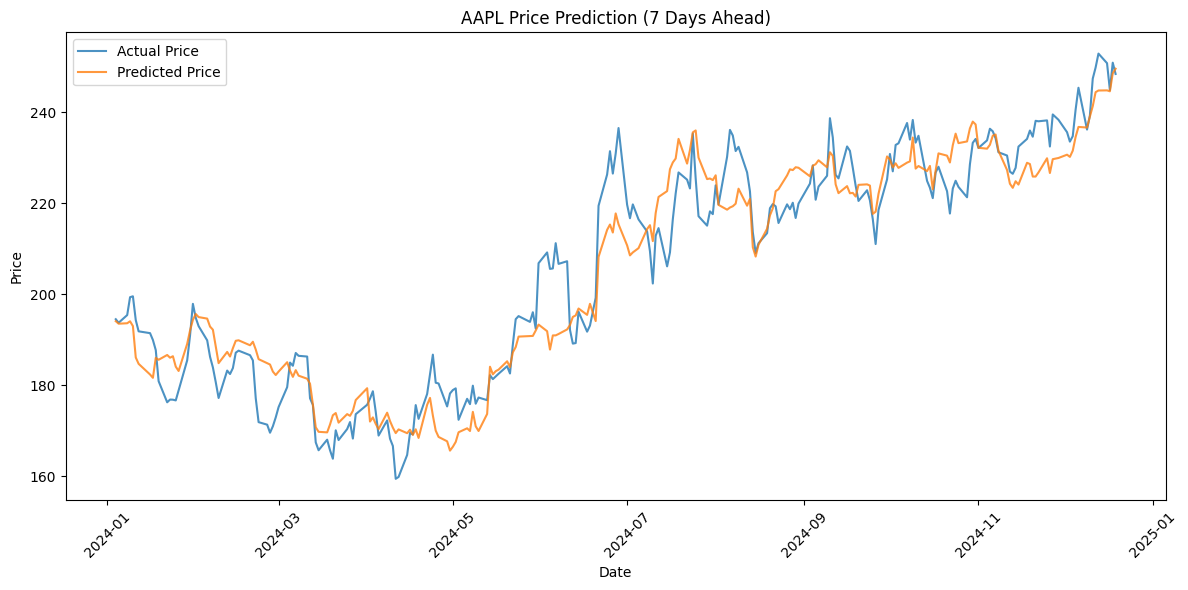

In [561]:
# Prepare data
X_train, X_test, y_train, y_test, dates_test, base_prices_test = prepare_data(
    AAPL_prices
)

# Train model
model, y_pred_returns = tune_and_train_xgboost(
    X_train, y_train, X_test, y_test
)  # Model predicts returns

predicted_prices = base_prices_test * (1 + y_pred_returns)
actual_prices = base_prices_test * (1 + y_test)

rmse_price = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print(f"\nFinal Price Root Mean Squared Error (RMSE) on Test Set: {rmse_price:.4f}")


# --- Plotting with actual dates ---
plt.figure(figsize=(12, 6))
plt.plot(dates_test, actual_prices, label="Actual Price", alpha=0.8)
plt.plot(dates_test, predicted_prices, label="Predicted Price", alpha=0.8)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("AAPL Price Prediction (7 Days Ahead)")  # Add title
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels if needed
plt.tight_layout()  # Adjust layout
plt.show()

Starting hyperparameter search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Search complete.
Best parameters found: {'colsample_bytree': np.float64(0.7400313630778703), 'gamma': np.float64(0.3225516810152824), 'learning_rate': np.float64(0.11033860894946494), 'max_depth': 3, 'reg_alpha': np.float64(0.9762149389902225), 'reg_lambda': np.float64(4.612260576307527), 'subsample': np.float64(0.7123089449763423)}
Best CV score (RMSE): 0.0591
Training final model with best parameters and early stopping...
Best iteration found by early stopping: 76

Final Root Mean Squared Error (RMSE) on Test Set: 0.0463

Final Price Root Mean Squared Error (RMSE) on Test Set: 8.5592


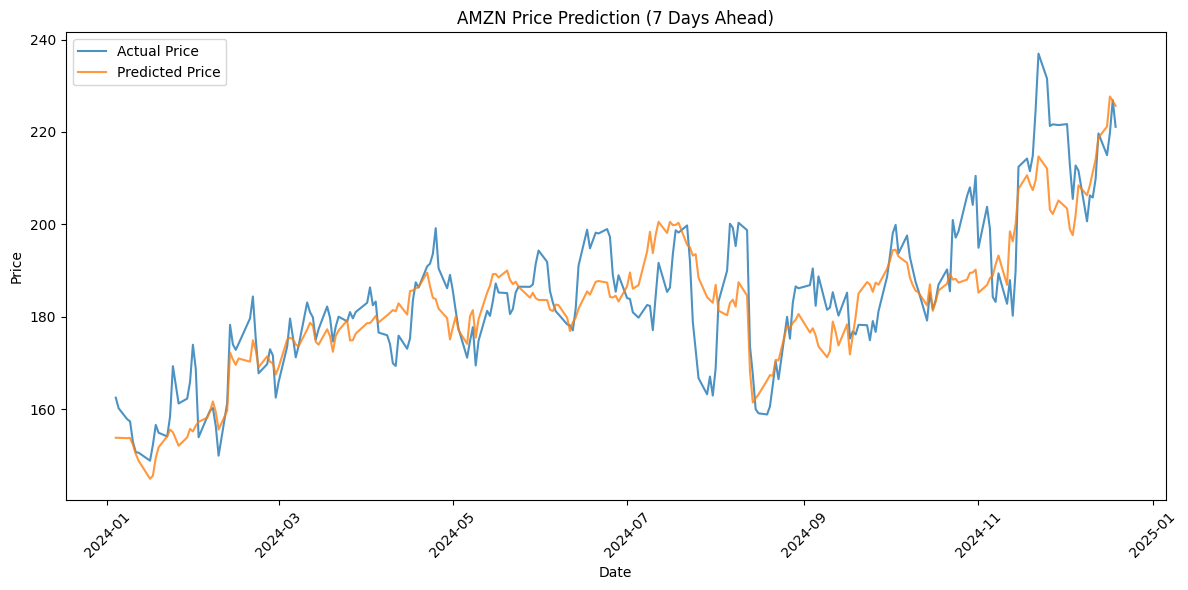

In [562]:
# Prepare data
X_train, X_test, y_train, y_test, dates_test, base_prices_test = prepare_data(
    AMZN_prices
)

# Train model
model, y_pred_returns = tune_and_train_xgboost(
    X_train, y_train, X_test, y_test
)  # Model predicts returns

predicted_prices = base_prices_test * (1 + y_pred_returns)
actual_prices = base_prices_test * (1 + y_test)

rmse_price = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print(f"\nFinal Price Root Mean Squared Error (RMSE) on Test Set: {rmse_price:.4f}")


# --- Plotting with actual dates ---
plt.figure(figsize=(12, 6))
plt.plot(dates_test, actual_prices, label="Actual Price", alpha=0.8)
plt.plot(dates_test, predicted_prices, label="Predicted Price", alpha=0.8)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("AMZN Price Prediction (7 Days Ahead)")  # Add title
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels if needed
plt.tight_layout()  # Adjust layout
plt.show()

Starting hyperparameter search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Search complete.
Best parameters found: {'colsample_bytree': np.float64(0.7312610669898928), 'gamma': np.float64(0.0775208083638721), 'learning_rate': np.float64(0.15727613324657966), 'max_depth': 4, 'reg_alpha': np.float64(4.302023091558376), 'reg_lambda': np.float64(2.25125680257932), 'subsample': np.float64(0.6155338937717693)}
Best CV score (RMSE): 0.0672
Training final model with best parameters and early stopping...
Best iteration found by early stopping: 0

Final Root Mean Squared Error (RMSE) on Test Set: 0.0542

Final Price Root Mean Squared Error (RMSE) on Test Set: 10.2265


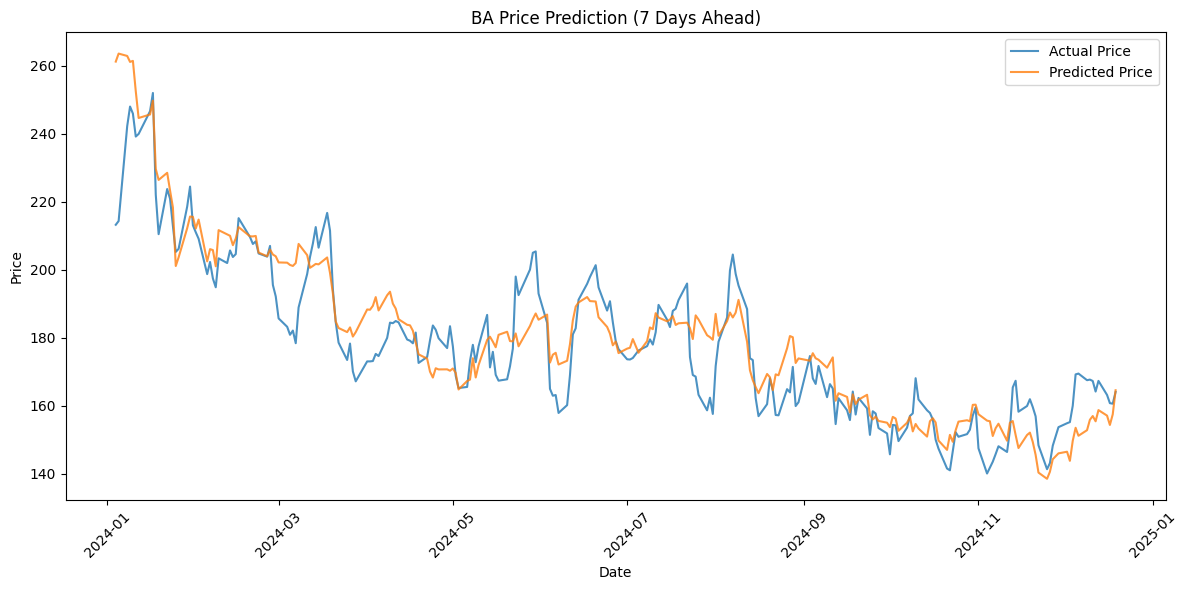

In [563]:
# Prepare data
X_train, X_test, y_train, y_test, dates_test, base_prices_test = prepare_data(
    BA_prices
)

# Train model
model, y_pred_returns = tune_and_train_xgboost(
    X_train, y_train, X_test, y_test
)  # Model predicts returns

predicted_prices = base_prices_test * (1 + y_pred_returns)
actual_prices = base_prices_test * (1 + y_test)

rmse_price = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print(f"\nFinal Price Root Mean Squared Error (RMSE) on Test Set: {rmse_price:.4f}")


# --- Plotting with actual dates ---
plt.figure(figsize=(12, 6))
plt.plot(dates_test, actual_prices, label="Actual Price", alpha=0.8)
plt.plot(dates_test, predicted_prices, label="Predicted Price", alpha=0.8)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("BA Price Prediction (7 Days Ahead)")  # Add title
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels if needed
plt.tight_layout()  # Adjust layout
plt.show()

Starting hyperparameter search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Search complete.
Best parameters found: {'colsample_bytree': np.float64(0.8065201393204782), 'gamma': np.float64(0.16147823647062298), 'learning_rate': np.float64(0.12927792921530554), 'max_depth': 5, 'reg_alpha': np.float64(2.1948571035281805), 'reg_lambda': np.float64(1.3922819067113297), 'subsample': np.float64(0.610140297366183)}
Best CV score (RMSE): 0.0509
Training final model with best parameters and early stopping...
Best iteration found by early stopping: 0

Final Root Mean Squared Error (RMSE) on Test Set: 0.0435

Final Price Root Mean Squared Error (RMSE) on Test Set: 15.1321


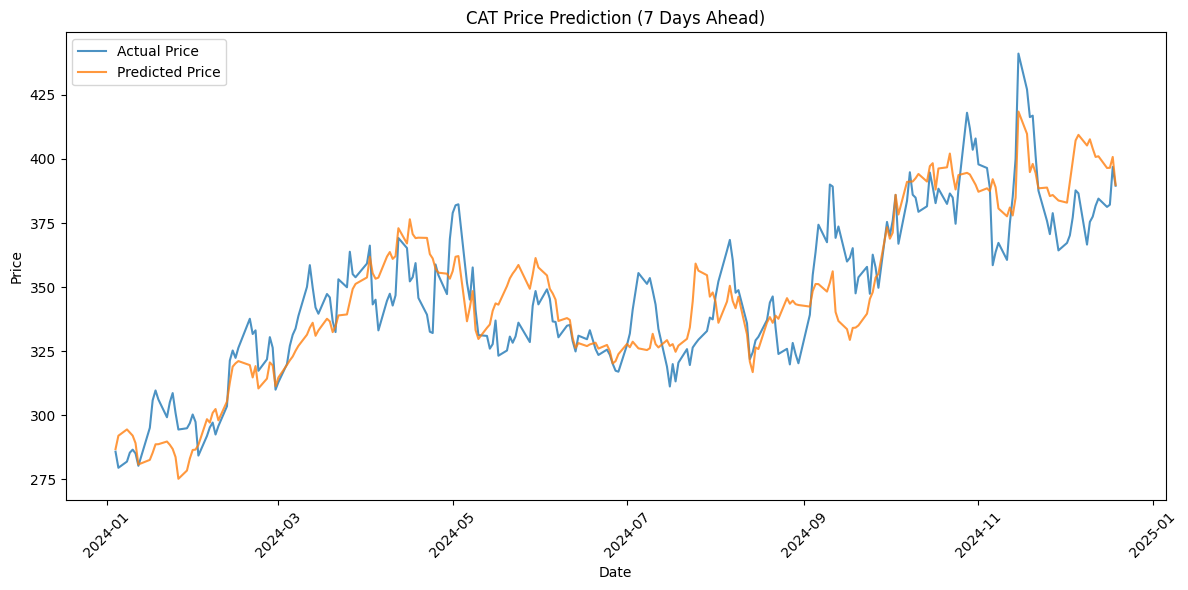

In [564]:
# Prepare data
X_train, X_test, y_train, y_test, dates_test, base_prices_test = prepare_data(
    CAT_prices
)

# Train model
model, y_pred_returns = tune_and_train_xgboost(
    X_train, y_train, X_test, y_test
)  # Model predicts returns

predicted_prices = base_prices_test * (1 + y_pred_returns)
actual_prices = base_prices_test * (1 + y_test)

rmse_price = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print(f"\nFinal Price Root Mean Squared Error (RMSE) on Test Set: {rmse_price:.4f}")


# --- Plotting with actual dates ---
plt.figure(figsize=(12, 6))
plt.plot(dates_test, actual_prices, label="Actual Price", alpha=0.8)
plt.plot(dates_test, predicted_prices, label="Predicted Price", alpha=0.8)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("CAT Price Prediction (7 Days Ahead)")  # Add title
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels if needed
plt.tight_layout()  # Adjust layout
plt.show()

Starting hyperparameter search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Search complete.
Best parameters found: {'colsample_bytree': np.float64(0.7400313630778703), 'gamma': np.float64(0.3225516810152824), 'learning_rate': np.float64(0.11033860894946494), 'max_depth': 3, 'reg_alpha': np.float64(0.9762149389902225), 'reg_lambda': np.float64(4.612260576307527), 'subsample': np.float64(0.7123089449763423)}
Best CV score (RMSE): 0.0483
Training final model with best parameters and early stopping...
Best iteration found by early stopping: 40

Final Root Mean Squared Error (RMSE) on Test Set: 0.0344

Final Price Root Mean Squared Error (RMSE) on Test Set: 5.2532


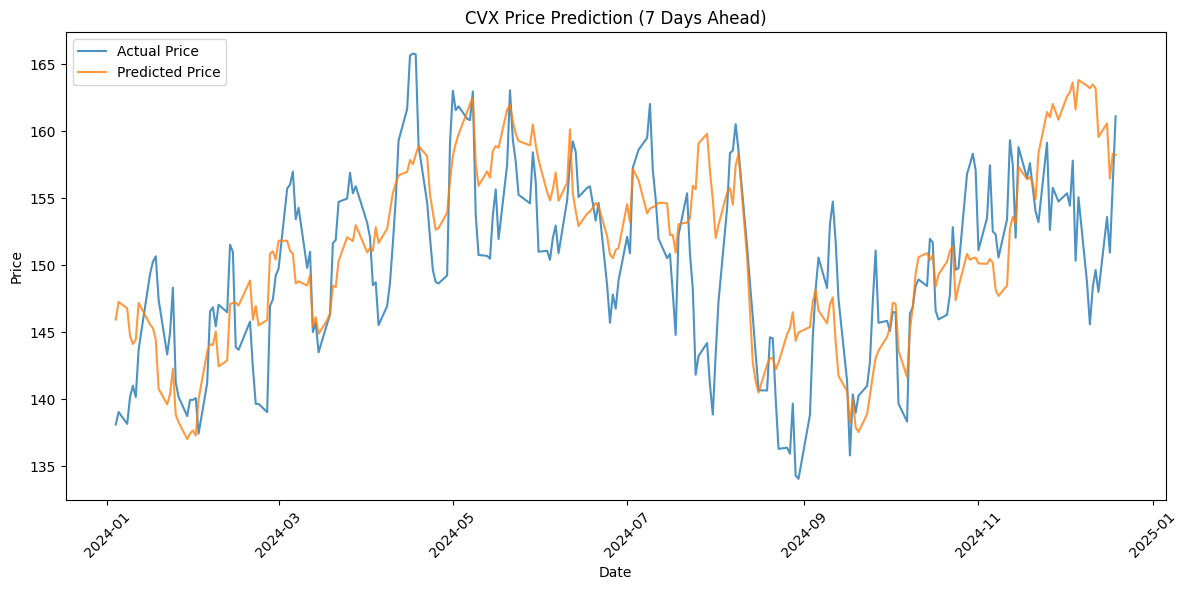

In [565]:
# Prepare data
X_train, X_test, y_train, y_test, dates_test, base_prices_test = prepare_data(
    CVX_prices
)

# Train model
model, y_pred_returns = tune_and_train_xgboost(
    X_train, y_train, X_test, y_test
)  # Model predicts returns

predicted_prices = base_prices_test * (1 + y_pred_returns)
actual_prices = base_prices_test * (1 + y_test)

rmse_price = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print(f"\nFinal Price Root Mean Squared Error (RMSE) on Test Set: {rmse_price:.4f}")


# --- Plotting with actual dates ---
plt.figure(figsize=(12, 6))
plt.plot(dates_test, actual_prices, label="Actual Price", alpha=0.8)
plt.plot(dates_test, predicted_prices, label="Predicted Price", alpha=0.8)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("CVX Price Prediction (7 Days Ahead)")  # Add title
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels if needed
plt.tight_layout()  # Adjust layout
plt.show()

Starting hyperparameter search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Search complete.
Best parameters found: {'colsample_bytree': np.float64(0.8194935157466344), 'gamma': np.float64(0.3459475988463466), 'learning_rate': np.float64(0.10779418892539007), 'max_depth': 3, 'reg_alpha': np.float64(0.8796262633867269), 'reg_lambda': np.float64(1.0903768180776043), 'subsample': np.float64(0.7975574860733738)}
Best CV score (RMSE): 0.0500
Training final model with best parameters and early stopping...
Best iteration found by early stopping: 89

Final Root Mean Squared Error (RMSE) on Test Set: 0.0389

Final Price Root Mean Squared Error (RMSE) on Test Set: 18.9405


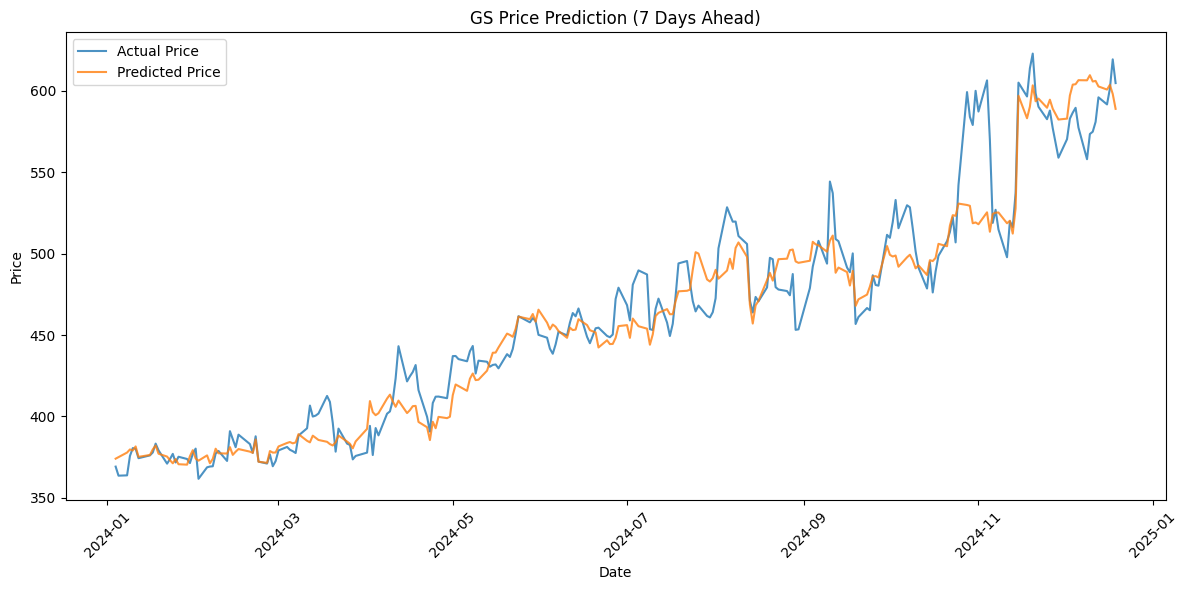

In [566]:
# Prepare data
X_train, X_test, y_train, y_test, dates_test, base_prices_test = prepare_data(
    GS_prices
)

# Train model
model, y_pred_returns = tune_and_train_xgboost(
    X_train, y_train, X_test, y_test
)  # Model predicts returns

predicted_prices = base_prices_test * (1 + y_pred_returns)
actual_prices = base_prices_test * (1 + y_test)

rmse_price = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print(f"\nFinal Price Root Mean Squared Error (RMSE) on Test Set: {rmse_price:.4f}")


# --- Plotting with actual dates ---
plt.figure(figsize=(12, 6))
plt.plot(dates_test, actual_prices, label="Actual Price", alpha=0.8)
plt.plot(dates_test, predicted_prices, label="Predicted Price", alpha=0.8)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("GS Price Prediction (7 Days Ahead)")  # Add title
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels if needed
plt.tight_layout()  # Adjust layout
plt.show()

Starting hyperparameter search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Search complete.
Best parameters found: {'colsample_bytree': np.float64(0.6661067756252009), 'gamma': np.float64(0.007818203370596966), 'learning_rate': np.float64(0.07351022210595544), 'max_depth': 3, 'reg_alpha': np.float64(0.993578407670862), 'reg_lambda': np.float64(1.027610585618012), 'subsample': np.float64(0.9261845713819337)}
Best CV score (RMSE): 0.0269
Training final model with best parameters and early stopping...
Best iteration found by early stopping: 17

Final Root Mean Squared Error (RMSE) on Test Set: 0.0244

Final Price Root Mean Squared Error (RMSE) on Test Set: 3.7281


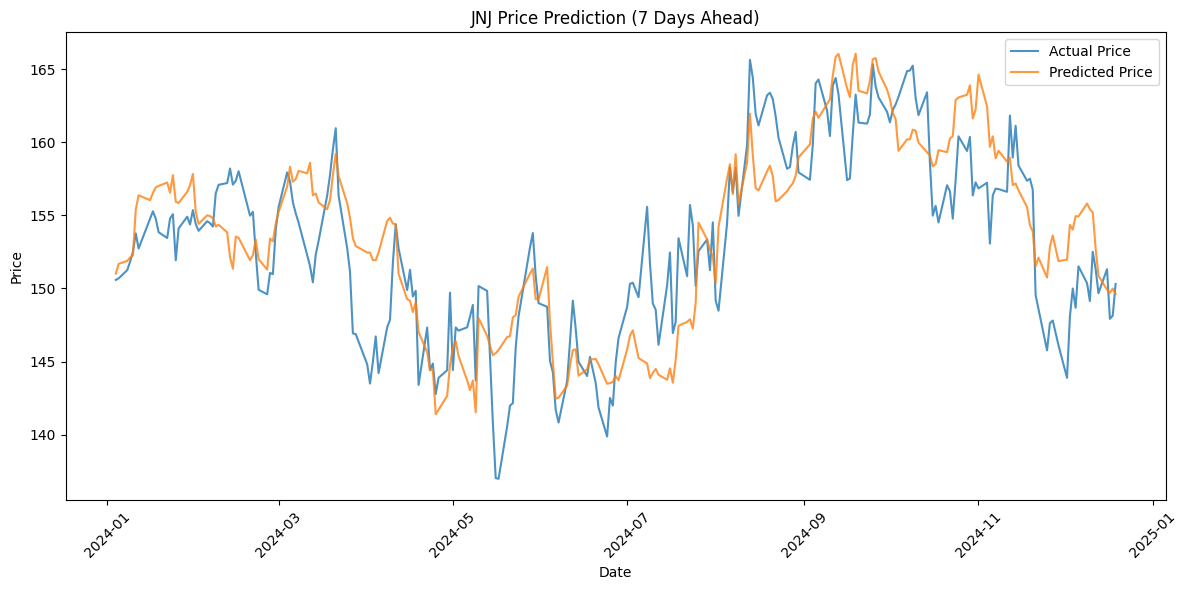

In [567]:
# Prepare data
X_train, X_test, y_train, y_test, dates_test, base_prices_test = prepare_data(
    JNJ_prices
)

# Train model
model, y_pred_returns = tune_and_train_xgboost(
    X_train, y_train, X_test, y_test
)  # Model predicts returns

predicted_prices = base_prices_test * (1 + y_pred_returns)
actual_prices = base_prices_test * (1 + y_test)

rmse_price = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print(f"\nFinal Price Root Mean Squared Error (RMSE) on Test Set: {rmse_price:.4f}")


# --- Plotting with actual dates ---
plt.figure(figsize=(12, 6))
plt.plot(dates_test, actual_prices, label="Actual Price", alpha=0.8)
plt.plot(dates_test, predicted_prices, label="Predicted Price", alpha=0.8)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("JNJ Price Prediction (7 Days Ahead)")  # Add title
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels if needed
plt.tight_layout()  # Adjust layout
plt.show()

Starting hyperparameter search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Search complete.
Best parameters found: {'colsample_bytree': np.float64(0.9579309401710595), 'gamma': np.float64(0.29894998940554257), 'learning_rate': np.float64(0.14828113525346753), 'max_depth': 6, 'reg_alpha': np.float64(0.22613644455269033), 'reg_lambda': np.float64(2.626651653816322), 'subsample': np.float64(0.7554709158757928)}
Best CV score (RMSE): 0.0451
Training final model with best parameters and early stopping...
Best iteration found by early stopping: 0

Final Root Mean Squared Error (RMSE) on Test Set: 0.0357

Final Price Root Mean Squared Error (RMSE) on Test Set: 7.3073


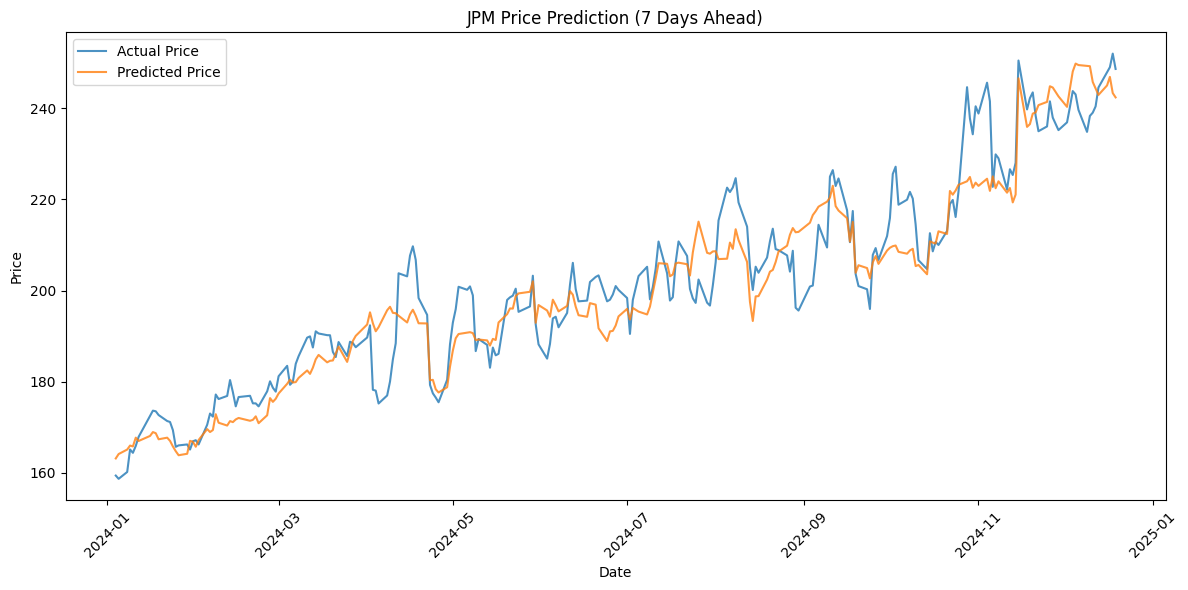

In [568]:
# Prepare data
X_train, X_test, y_train, y_test, dates_test, base_prices_test = prepare_data(
    JPM_prices
)

# Train model
model, y_pred_returns = tune_and_train_xgboost(
    X_train, y_train, X_test, y_test
)  # Model predicts returns

predicted_prices = base_prices_test * (1 + y_pred_returns)
actual_prices = base_prices_test * (1 + y_test)

rmse_price = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print(f"\nFinal Price Root Mean Squared Error (RMSE) on Test Set: {rmse_price:.4f}")


# --- Plotting with actual dates ---
plt.figure(figsize=(12, 6))
plt.plot(dates_test, actual_prices, label="Actual Price", alpha=0.8)
plt.plot(dates_test, predicted_prices, label="Predicted Price", alpha=0.8)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("JPM Price Prediction (7 Days Ahead)")  # Add title
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels if needed
plt.tight_layout()  # Adjust layout
plt.show()

Starting hyperparameter search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Search complete.
Best parameters found: {'colsample_bytree': np.float64(0.7367518666865607), 'gamma': np.float64(0.04589953290672094), 'learning_rate': np.float64(0.024123548240284017), 'max_depth': 6, 'reg_alpha': np.float64(0.8766513494466927), 'reg_lambda': np.float64(1.0858055091587513), 'subsample': np.float64(0.9053457692015644)}
Best CV score (RMSE): 0.0411
Training final model with best parameters and early stopping...
Best iteration found by early stopping: 26

Final Root Mean Squared Error (RMSE) on Test Set: 0.0327

Final Price Root Mean Squared Error (RMSE) on Test Set: 13.8346


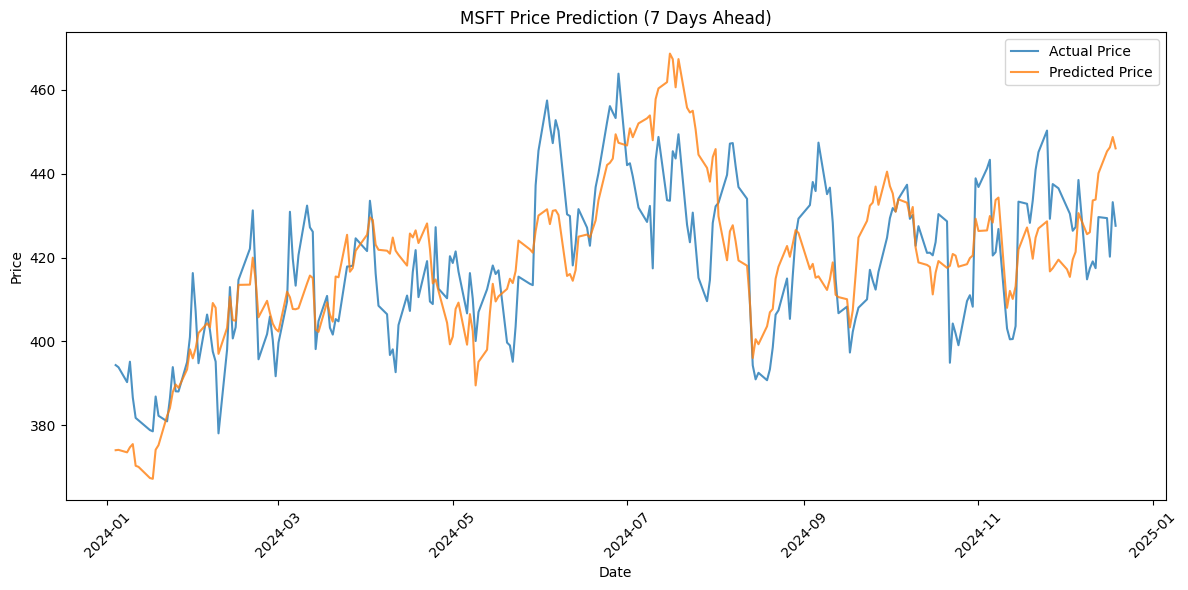

In [569]:
# Prepare data
X_train, X_test, y_train, y_test, dates_test, base_prices_test = prepare_data(
    MSFT_prices
)

# Train model
model, y_pred_returns = tune_and_train_xgboost(
    X_train, y_train, X_test, y_test
)  # Model predicts returns

predicted_prices = base_prices_test * (1 + y_pred_returns)
actual_prices = base_prices_test * (1 + y_test)

rmse_price = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print(f"\nFinal Price Root Mean Squared Error (RMSE) on Test Set: {rmse_price:.4f}")


# --- Plotting with actual dates ---
plt.figure(figsize=(12, 6))
plt.plot(dates_test, actual_prices, label="Actual Price", alpha=0.8)
plt.plot(dates_test, predicted_prices, label="Predicted Price", alpha=0.8)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("MSFT Price Prediction (7 Days Ahead)")  # Add title
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels if needed
plt.tight_layout()  # Adjust layout
plt.show()

Starting hyperparameter search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Search complete.
Best parameters found: {'colsample_bytree': np.float64(0.7367518666865607), 'gamma': np.float64(0.04589953290672094), 'learning_rate': np.float64(0.024123548240284017), 'max_depth': 6, 'reg_alpha': np.float64(0.8766513494466927), 'reg_lambda': np.float64(1.0858055091587513), 'subsample': np.float64(0.9053457692015644)}
Best CV score (RMSE): 0.0453
Training final model with best parameters and early stopping...
Best iteration found by early stopping: 0

Final Root Mean Squared Error (RMSE) on Test Set: 0.0409

Final Price Root Mean Squared Error (RMSE) on Test Set: 2.8353


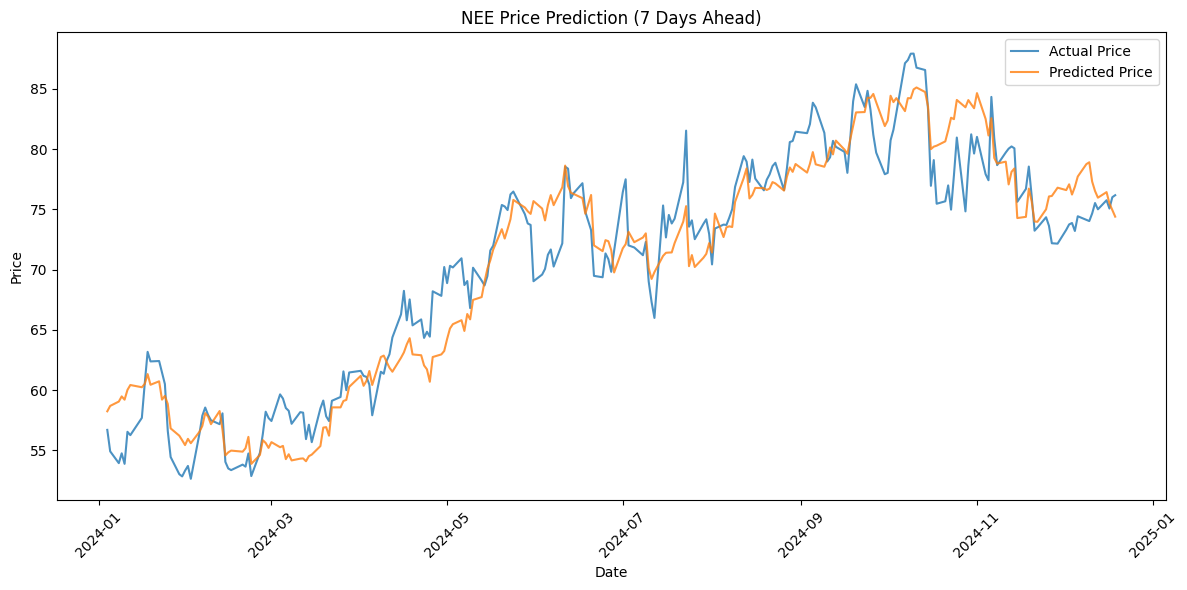

In [570]:
# Prepare data
X_train, X_test, y_train, y_test, dates_test, base_prices_test = prepare_data(
    NEE_prices
)

# Train model
model, y_pred_returns = tune_and_train_xgboost(
    X_train, y_train, X_test, y_test
)  # Model predicts returns

predicted_prices = base_prices_test * (1 + y_pred_returns)
actual_prices = base_prices_test * (1 + y_test)

rmse_price = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print(f"\nFinal Price Root Mean Squared Error (RMSE) on Test Set: {rmse_price:.4f}")


# --- Plotting with actual dates ---
plt.figure(figsize=(12, 6))
plt.plot(dates_test, actual_prices, label="Actual Price", alpha=0.8)
plt.plot(dates_test, predicted_prices, label="Predicted Price", alpha=0.8)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("NEE Price Prediction (7 Days Ahead)")  # Add title
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels if needed
plt.tight_layout()  # Adjust layout
plt.show()

Starting hyperparameter search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Search complete.
Best parameters found: {'colsample_bytree': np.float64(0.8065201393204782), 'gamma': np.float64(0.16147823647062298), 'learning_rate': np.float64(0.12927792921530554), 'max_depth': 5, 'reg_alpha': np.float64(2.1948571035281805), 'reg_lambda': np.float64(1.3922819067113297), 'subsample': np.float64(0.610140297366183)}
Best CV score (RMSE): 0.0851
Training final model with best parameters and early stopping...
Best iteration found by early stopping: 117

Final Root Mean Squared Error (RMSE) on Test Set: 0.0840

Final Price Root Mean Squared Error (RMSE) on Test Set: 8.8082


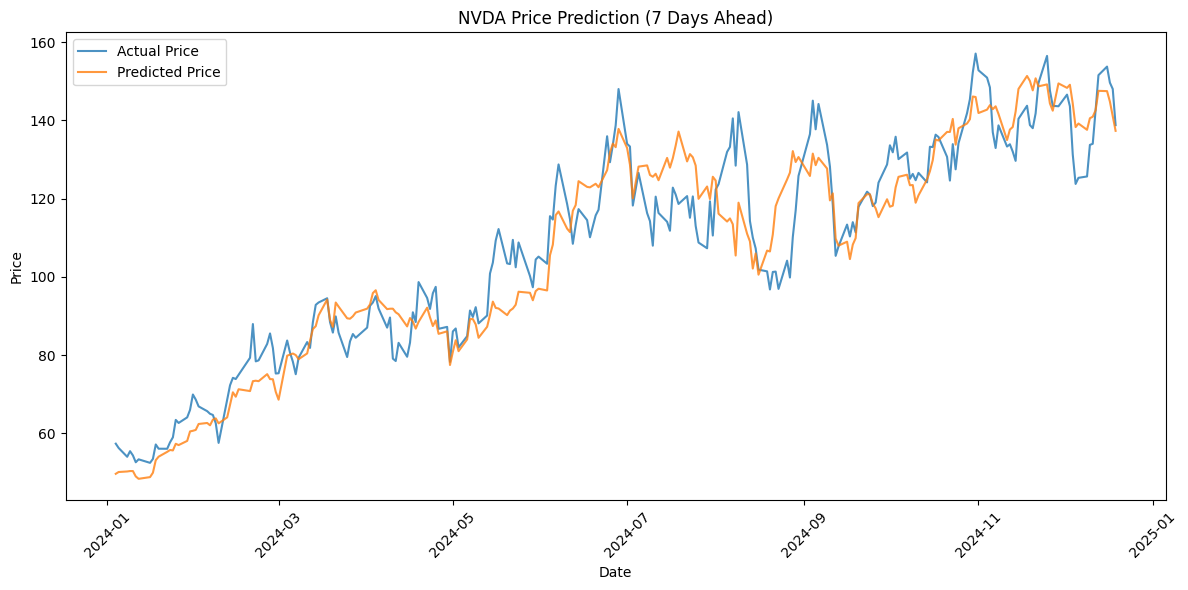

In [571]:
# Prepare data
X_train, X_test, y_train, y_test, dates_test, base_prices_test = prepare_data(
    NVDA_prices
)

# Train model
model, y_pred_returns = tune_and_train_xgboost(
    X_train, y_train, X_test, y_test
)  # Model predicts returns

predicted_prices = base_prices_test * (1 + y_pred_returns)
actual_prices = base_prices_test * (1 + y_test)

rmse_price = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print(f"\nFinal Price Root Mean Squared Error (RMSE) on Test Set: {rmse_price:.4f}")


# --- Plotting with actual dates ---
plt.figure(figsize=(12, 6))
plt.plot(dates_test, actual_prices, label="Actual Price", alpha=0.8)
plt.plot(dates_test, predicted_prices, label="Predicted Price", alpha=0.8)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("NVDA Price Prediction (7 Days Ahead)")  # Add title
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels if needed
plt.tight_layout()  # Adjust layout
plt.show()

Starting hyperparameter search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Search complete.
Best parameters found: {'colsample_bytree': np.float64(0.6161734358153725), 'gamma': np.float64(0.3553314448428937), 'learning_rate': np.float64(0.026633623121774697), 'max_depth': 6, 'reg_alpha': np.float64(0.5394571349665223), 'reg_lambda': np.float64(1.1571459284336711), 'subsample': np.float64(0.8545641645055122)}
Best CV score (RMSE): 0.0456
Training final model with best parameters and early stopping...
Best iteration found by early stopping: 14

Final Root Mean Squared Error (RMSE) on Test Set: 0.0364

Final Price Root Mean Squared Error (RMSE) on Test Set: 0.9672


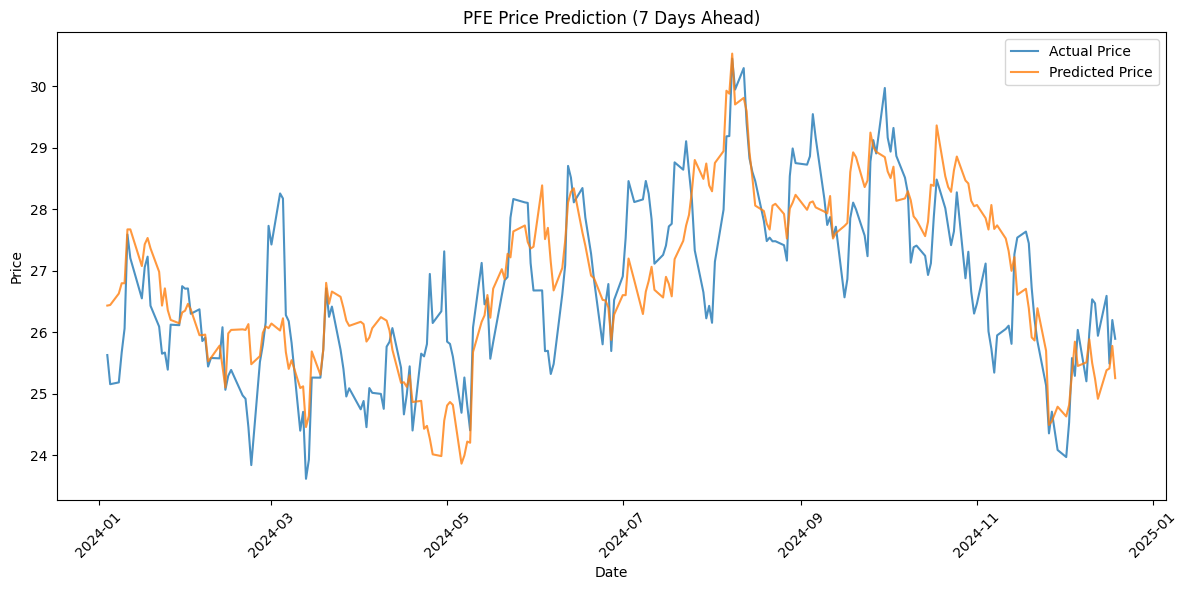

In [572]:
# Prepare data
X_train, X_test, y_train, y_test, dates_test, base_prices_test = prepare_data(
    PFE_prices
)

# Train model
model, y_pred_returns = tune_and_train_xgboost(
    X_train, y_train, X_test, y_test
)  # Model predicts returns

predicted_prices = base_prices_test * (1 + y_pred_returns)
actual_prices = base_prices_test * (1 + y_test)

rmse_price = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print(f"\nFinal Price Root Mean Squared Error (RMSE) on Test Set: {rmse_price:.4f}")


# --- Plotting with actual dates ---
plt.figure(figsize=(12, 6))
plt.plot(dates_test, actual_prices, label="Actual Price", alpha=0.8)
plt.plot(dates_test, predicted_prices, label="Predicted Price", alpha=0.8)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("PFE Price Prediction (7 Days Ahead)")  # Add title
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels if needed
plt.tight_layout()  # Adjust layout
plt.show()

Starting hyperparameter search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Search complete.
Best parameters found: {'colsample_bytree': np.float64(0.8042989210310263), 'gamma': np.float64(0.2087055015743895), 'learning_rate': np.float64(0.04331617157060954), 'max_depth': 5, 'reg_alpha': np.float64(1.3470616689926074), 'reg_lambda': np.float64(2.220627611238871), 'subsample': np.float64(0.6673164168691722)}
Best CV score (RMSE): 0.1018
Training final model with best parameters and early stopping...
Best iteration found by early stopping: 228

Final Root Mean Squared Error (RMSE) on Test Set: 0.1120

Final Price Root Mean Squared Error (RMSE) on Test Set: 26.0339


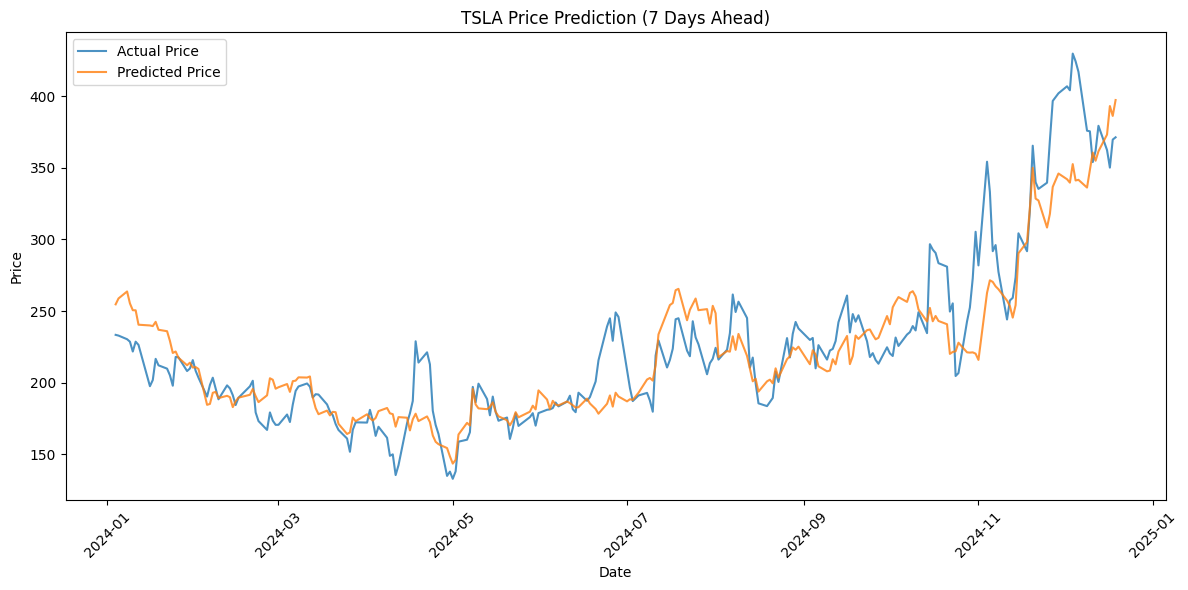

In [573]:
# Prepare data
X_train, X_test, y_train, y_test, dates_test, base_prices_test = prepare_data(
    TSLA_prices
)

# Train model
model, y_pred_returns = tune_and_train_xgboost(
    X_train, y_train, X_test, y_test
)  # Model predicts returns

predicted_prices = base_prices_test * (1 + y_pred_returns)
actual_prices = base_prices_test * (1 + y_test)

rmse_price = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print(f"\nFinal Price Root Mean Squared Error (RMSE) on Test Set: {rmse_price:.4f}")


# --- Plotting with actual dates ---
plt.figure(figsize=(12, 6))
plt.plot(dates_test, actual_prices, label="Actual Price", alpha=0.8)
plt.plot(dates_test, predicted_prices, label="Predicted Price", alpha=0.8)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("TSLA Price Prediction (7 Days Ahead)")  # Add title
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels if needed
plt.tight_layout()  # Adjust layout
plt.show()

Starting hyperparameter search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Search complete.
Best parameters found: {'colsample_bytree': np.float64(0.6836286482950855), 'gamma': np.float64(0.2707239869137829), 'learning_rate': np.float64(0.11436765990176231), 'max_depth': 6, 'reg_alpha': np.float64(0.8747746354796809), 'reg_lambda': np.float64(5.910841716647178), 'subsample': np.float64(0.8066543565084057)}
Best CV score (RMSE): 0.0526
Training final model with best parameters and early stopping...
Best iteration found by early stopping: 112

Final Root Mean Squared Error (RMSE) on Test Set: 0.0337

Final Price Root Mean Squared Error (RMSE) on Test Set: 3.8045


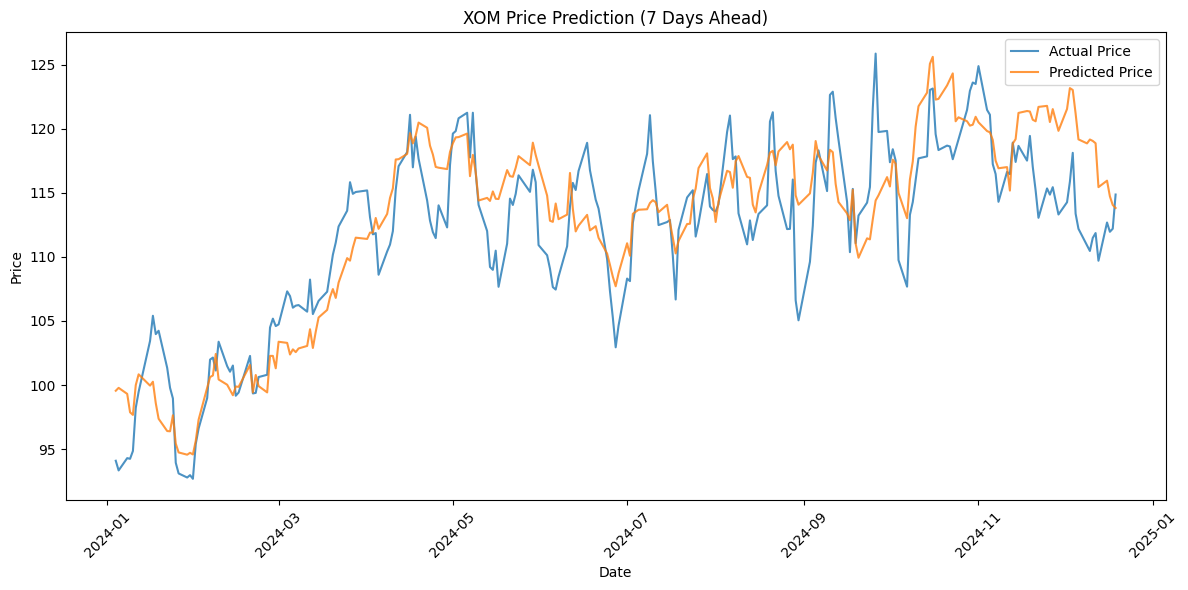

In [574]:
# Prepare data
X_train, X_test, y_train, y_test, dates_test, base_prices_test = prepare_data(
    XOM_prices
)

# Train model
model, y_pred_returns = tune_and_train_xgboost(
    X_train, y_train, X_test, y_test
)  # Model predicts returns

predicted_prices = base_prices_test * (1 + y_pred_returns)
actual_prices = base_prices_test * (1 + y_test)

rmse_price = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print(f"\nFinal Price Root Mean Squared Error (RMSE) on Test Set: {rmse_price:.4f}")


# --- Plotting with actual dates ---
plt.figure(figsize=(12, 6))
plt.plot(dates_test, actual_prices, label="Actual Price", alpha=0.8)
plt.plot(dates_test, predicted_prices, label="Predicted Price", alpha=0.8)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("XOM Price Prediction (7 Days Ahead)")  # Add title
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels if needed
plt.tight_layout()  # Adjust layout
plt.show()